In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
df_raw = pd.read_csv('data.csv')
df= df_raw.copy()
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace=True)
df['Price']= df['Price'].str.replace(',',"").astype(float)




<ipython-input-150-b11b6c12bd48>:3: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df.Date = pd.to_datetime(df.Date, dayfirst = True)


In [ ]:
df["Price"].dtype

dtype('float64')

In [ ]:
df.head()

,Price
Date,
2023-08-17,48386.12
2023-08-16,48146.43
2023-08-15,48565.75
2023-11-08,48424.40
2023-10-08,47808.34


<Axes: xlabel='Date'>

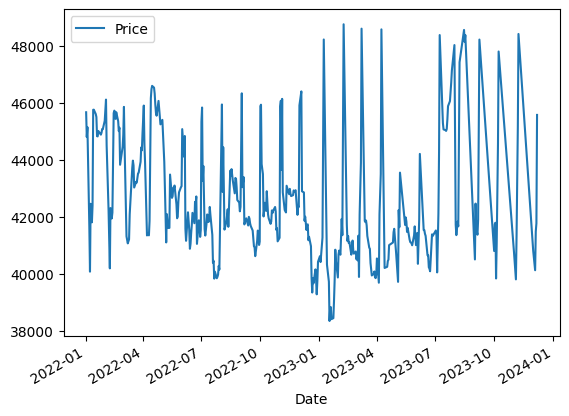

In [ ]:
df.plot()

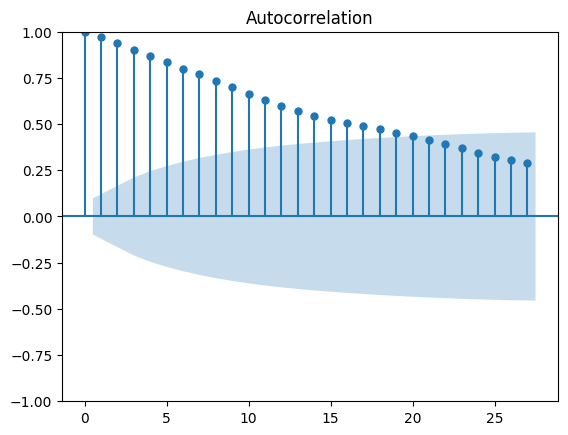

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df)
plt.show()

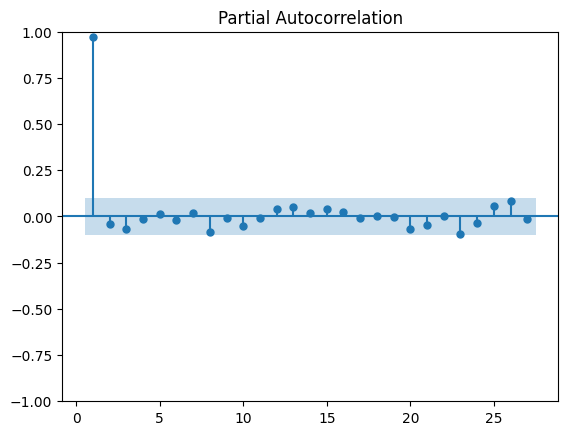

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df,zero=False)
plt.show()

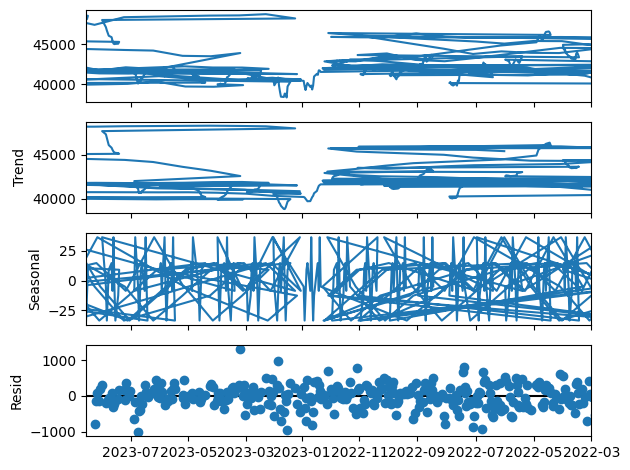

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = df
result = seasonal_decompose(series, model='additive',period=7)
result.plot()
pyplot.show()

In [ ]:
x = df.values
split = round(len(x)/2)
x1 = x[0:split]
x2 = x[split:]
print("Mean1 =%f" % x1.mean())
print("Mean2 =%f" % x2.mean())
print("Variance1 =%f" % x1.var())
print("Variance2 =%f" % x2.var())

Mean1 =41954.079000
Mean2 =43199.462985
Variance1 =5080217.333700
Variance2 =3189298.490196


In [ ]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(x)
results
print("ADF Statistics: %f" % results[0])
print("p-value: %f" % results[1])
print("Critical Values: ")
for key , values in results[4].items():
  print( "\t%s: %f" % (key , values))
if (results[1]>0.05):
  print("Series is not stationary")
else:
  print("Series is stationary")

ADF Statistics: -2.802991
p-value: 0.057848
Critical Values: 
	1%: -3.446804
	5%: -2.868793
	10%: -2.570634
Series is not stationary


In [ ]:
from statsmodels.tsa.stattools import kpss
result = kpss(df)
print("p-values are: %f " % result[1])

p-values are: 0.010000 


<ipython-input-132-a6ec2ba704c2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df)


In [ ]:
size = int(len(df)*0.8)
df, df_test = df.iloc[:size], df.iloc[size:]

In [ ]:
df.size

401

In [ ]:
df_test.size

81

In [ ]:
model=ARIMA(df,order=(1,1,2),seasonal_order=(1,1,1,30))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [ ]:
result = model.fit()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions = result.predict(start=len(df+1), end= len(df)+len(df_test)-1, dynamic=False)

rmse = sqrt(mean_squared_error(df_test.Price, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5045.142


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
test=df_test

In [ ]:
test['prediction']=predictions

In [ ]:
test.head()

,Price,prediction
Date,,
2022-10-17,41755.45,39887.640525
2022-10-18,41839.26,38597.724126
2022-10-19,42226.05,38788.473907
2022-10-20,42137.04,38907.034878
2022-10-21,42213.48,39134.703276


In [ ]:
test['difference']=test["Price"]-test['prediction']

In [ ]:
df2 = pd.DataFrame({'Actual': test.Price, 'Predicted': test.prediction})
df2.head()

,Actual,Predicted
Date,,
2022-10-17,41755.45,39887.640525
2022-10-18,41839.26,38597.724126
2022-10-19,42226.05,38788.473907
2022-10-20,42137.04,38907.034878
2022-10-21,42213.48,39134.703276


<Axes: xlabel='Date'>

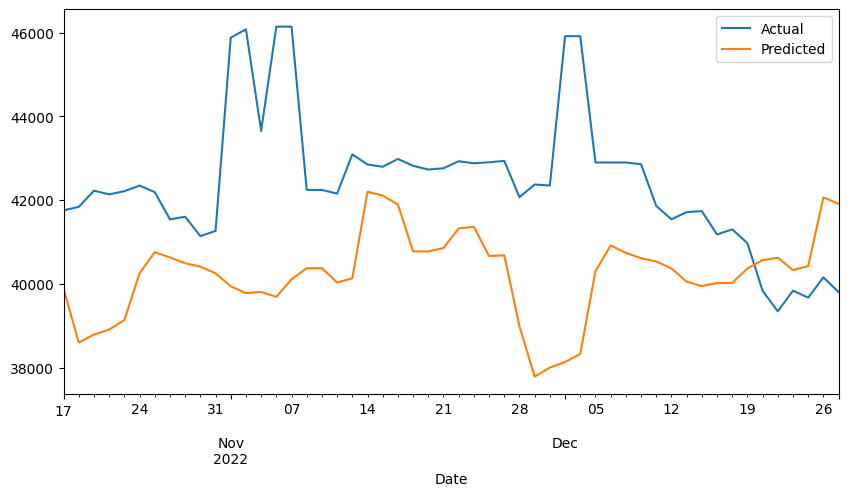

In [ ]:
df2.plot(kind='line',figsize=(10,5))

In [ ]:
def evaluate_arima_model(data, arima_order , train , test):

    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions

In [ ]:
mse, test, predictions = evaluate_arima_model(df['Date'] , arima_order=(1, 1,1) , df , df_test)

SyntaxError: ignored